In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from analysis.correlation_of_correlations import *
from common.helpers import get_graphemes, get_phonemes

sns.set_style('darkgrid')

## Load Activation Data

In [3]:
anchor_probe_mapping = pd.read_pickle(f'../../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [4]:
all_data = []
for dilution in range(1, 4):
    # Load anchors data
    hidden_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-probes-hidden.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-hidden.pkl')])
    hidden_data['epoch'] = hidden_data['epoch'].astype(int)
    hidden_data = hidden_data[hidden_data['word_type'].isin(['PRO_REG', 'PRO_EXC', 'PRO_AMB'])]
    hidden_data = hidden_data.drop_duplicates(subset=['epoch', 'orth'])
    
    output_data = pd.concat([pd.read_pickle(f'../pmsp-recurrent-dt-100-seed-1/activations-probes-output.pkl'),
                             pd.read_pickle(f'../pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-probes-output.pkl')])
    output_data['epoch'] = output_data['epoch'].astype(int)
    output_data = output_data[output_data['word_type'].isin(['PRO_REG', 'PRO_EXC', 'PRO_AMB'])]
    output_data = output_data.drop_duplicates(subset=['epoch', 'orth'])
    
    activations_data = pd.merge(hidden_data[['epoch', 'orth', 'hidden']], output_data, 
                                how='left', on=['epoch', 'orth']).reset_index(drop=True)
    activations_data['dilution'] = dilution
    all_data.append(activations_data)
    
all_data = pd.concat(all_data)
all_data = all_data.drop(columns=['target'])

In [5]:
# find input representations
inputs = []
for orth in all_data['orth'].unique():
    inputs.append({'orth': orth, 'input': get_graphemes(orth)})
inputs = pd.DataFrame(inputs)
all_data = all_data.merge(inputs, on='orth')

In [6]:
# find target representations
targets = []
for phon in all_data['phon'].unique():
    targets.append({'phon': phon, 'target': get_phonemes(phon)})
targets = pd.DataFrame(targets)
all_data = all_data.merge(targets, on='phon')

In [7]:
all_data['word_type'] = all_data['word_type'].replace({'PRO_REG': 'Regular',
                                                       'PRO_AMB': 'Ambiguous',
                                                       'PRO_EXC': 'Exception'})

In [8]:
all_data.head()

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target
0,0,tisp,"[0.373897, 0.03446266, 0.2112158, 0.9945962, 0...","[0.987653, 0.9250819, 0.6455368, 0.9980932, 0....",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,50,tisp,"[0.695536, 0.05105973, 0.2703764, 0.6722665, 0...","[0.2990438, 0.09986782, 0.01104023, 0.00744819...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,100,tisp,"[0.7200769, 0.07116238, 0.1765733, 0.6095342, ...","[0.3698868, 0.04017891, 0.004660575, 0.0065370...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
3,150,tisp,"[0.7591655, 0.0856965, 0.0641764, 0.6542616, 0...","[0.2994674, 0.02580502, 0.001543103, 0.0119613...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,200,tisp,"[0.8146111, 0.09398907, 0.04292496, 0.681992, ...","[0.1733097, 0.01252688, 0.0006066441, 0.013739...",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


## Calculate Correlation Vectors

In [9]:
regulars = all_data[all_data['word_type'] == 'Regular']
exceptions = all_data[all_data['word_type'] == 'Exception']
ambiguous = all_data[all_data['word_type'] == 'Ambiguous']

regulars = calculate_correlation_vectors(regulars)
exceptions = calculate_correlation_vectors(exceptions)
ambiguous = calculate_correlation_vectors(ambiguous)

100%|██████████| 78/78 [00:09<00:00,  8.25it/s]


## Calculate Correlation of Correlations

In [10]:
regulars = calculate_cross_layer_correlation(regulars)
exceptions = calculate_cross_layer_correlation(exceptions)
ambiguous = calculate_cross_layer_correlation(ambiguous)

In [11]:
regulars.head()

,epoch,orth,hidden,output,word_id,phon,word_type,dilution,input,target,input_corr_vector,hidden_corr_vector,output_corr_vector,target_corr_vector,orth_hidden_corr,hidden_phon_corr,orth_phon_corr,orth_target_corr
0,0,tisp,"[0.373897, 0.03446266, 0.2112158, 0.9945962, 0...","[0.987653, 0.9250819, 0.6455368, 0.9980932, 0....",19,tisp,Regular,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.22029702970297035, -0.03960396039603961, 0....","[0.8875730503764879, 0.858667573387083, 0.8761...","[0.9649753949882943, 0.9301970423790109, 0.966...","[0.1973684210526316, 0.16226969413320902, 0.19...",0.880980,0.741571,0.616967,0.946440
1,0,smig,"[0.3826611, 0.1655288, 0.3533417, 0.9962382, 0...","[0.9928132, 0.9297768, 0.6394547, 0.9987586, 0...",23,smig,Regular,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.22029702970297035, -0.039603960396039646, -...","[0.8875730503764879, 0.8496127220102927, 0.798...","[0.9649753949882943, 0.9128636790242117, 0.931...","[0.1973684210526316, 0.16226969413320905, -0.0...",0.753885,0.748710,0.621832,0.895699
2,0,drax,"[0.623893, 0.1842021, 0.1536709, 0.9782502, 0....","[0.9125429, 0.6072306, 0.705579, 0.9985097, 0....",5,drks,Regular,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[-0.03960396039603961, -0.039603960396039646, ...","[0.858667573387083, 0.8496127220102927, 0.8214...","[0.9301970423790109, 0.9128636790242117, 0.945...","[0.16226969413320902, 0.16226969413320905, 0.1...",0.776118,0.715216,0.543915,0.773143
3,0,clape,"[0.3469152, 0.1099833, 0.7027258, 0.997197, 0....","[0.9965884, 0.8531621, 0.5863744, 0.9961922, 0...",37,klAp,Regular,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.18912251778324363, -0.04449941594899852, 0....","[0.8761701184697583, 0.7989720984418196, 0.821...","[0.9667668130072021, 0.9312434510837932, 0.945...","[0.1973684210526316, -0.07017543859649124, 0.1...",0.863304,0.742091,0.767086,0.912978
4,0,creef,"[0.6107419, 0.3990873, 0.1783869, 0.9808449, 0...","[0.9803765, 0.6357031, 0.7612401, 0.991789, 0....",10,krEf,Regular,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[-0.044499415948998464, -0.04449941594899848, ...","[0.834996909078557, 0.8216377821498073, 0.8564...","[0.938181699503053, 0.9253527313443096, 0.9698...","[-0.07017543859649125, -0.07017543859649124, 0...",0.882916,0.747039,0.772196,0.861961


In [12]:
accum = []
for df in [regulars, ambiguous, exceptions]:
    for col in ['orth_hidden_corr', 'hidden_phon_corr', 'orth_phon_corr', 'orth_target_corr']:
        temp = df[['epoch', 'orth', 'word_type', 'dilution']]
        temp['corr'] = df[col]
        temp['corr_type'] = col.rstrip('_corr').replace('_', '-').title()
        accum.append(temp)
all_data = pd.concat(accum)
all_data = all_data.rename(columns={'word_type': 'type'})

In [13]:
accum = []
for row in anchor_probe_mapping['probes'].values:
    for probe in row:
        accum.append({'probe': probe, 'first_probe': row[0]})
anchor_groups = pd.DataFrame(accum)

In [14]:
all_data = all_data.merge(anchor_groups, left_on='orth', right_on='probe')
all_data = all_data.groupby(by=['epoch', 'dilution', 'type', 'corr_type', 'first_probe']).mean()
all_data = all_data.reset_index(drop=False)

In [15]:
all_data.head()

,epoch,dilution,type,corr_type,first_probe,corr
0,0,1,Ambiguous,Hidden-Phon,blone,0.754167
1,0,1,Ambiguous,Hidden-Phon,brour,0.812758
2,0,1,Ambiguous,Hidden-Phon,ghow,0.588031
3,0,1,Ambiguous,Hidden-Phon,glead,0.667193
4,0,1,Ambiguous,Hidden-Phon,glood,0.670484


## Plot Results

In [16]:
TYPE_ORDER = ['Regular', 'Ambiguous', 'Exception']
CORR_TYPE_ORDER = ['Orth-Hidden', 'Hidden-Phon', 'Orth-Phon', 'Orth-Target']

In [17]:
all_data = all_data[all_data['epoch'] >= 100]
all_data_small = all_data[all_data['epoch'] % 100 == 0]

### All Dilution Levels

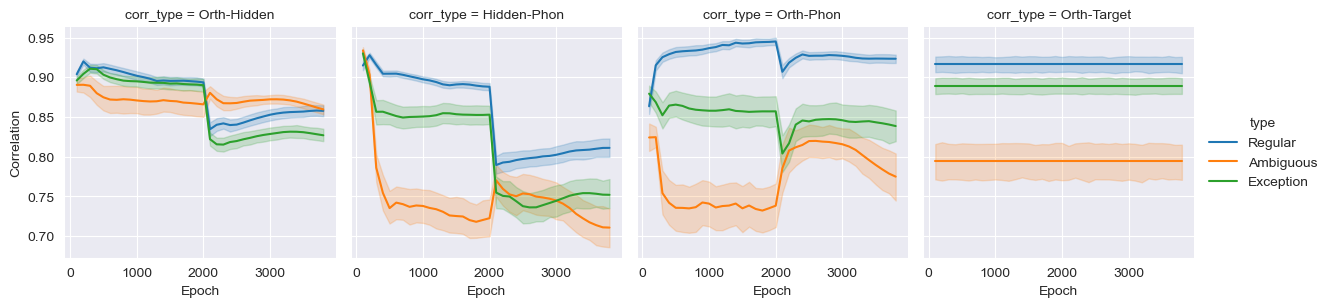

In [18]:
g = sns.FacetGrid(all_data_small, col='corr_type', hue='type', col_order=CORR_TYPE_ORDER, hue_order=TYPE_ORDER)
g.map_dataframe(sns.lineplot, x='epoch', y='corr', ci=68)
g.set_axis_labels("Epoch", "Correlation")
g.add_legend()
plt.show()

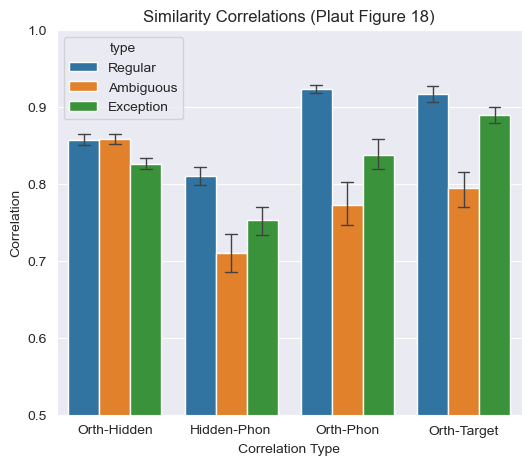

In [19]:
generate_correlation_of_correlations_barplot(all_data, epoch=all_data['epoch'].max(), ylim=(0.5, 1.0),
                                             hue_order=TYPE_ORDER, order=CORR_TYPE_ORDER)

### Individual Dilution Levels

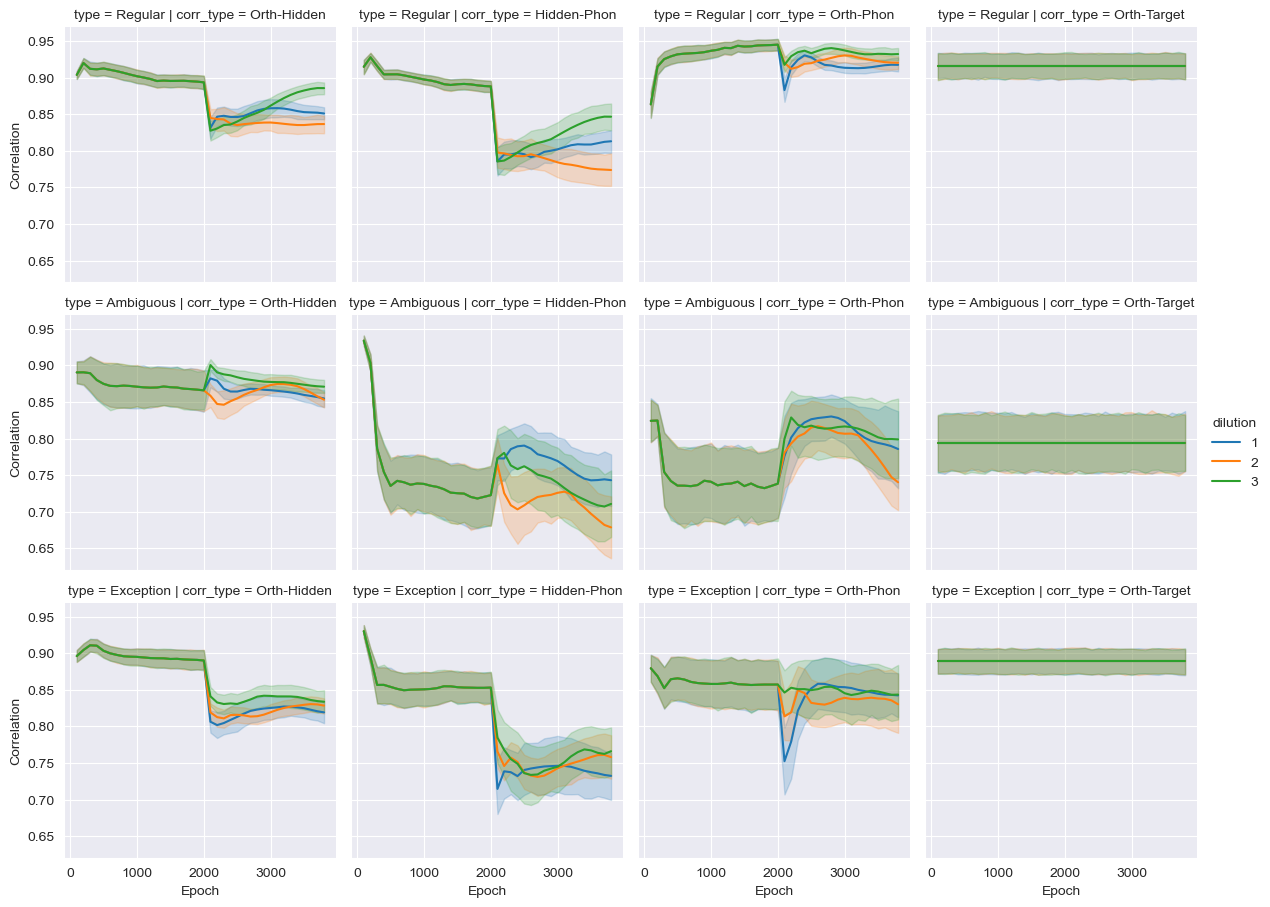

In [20]:
g = sns.FacetGrid(all_data_small, col='corr_type', row='type', hue='dilution', 
                  col_order=CORR_TYPE_ORDER, row_order=TYPE_ORDER)
g.map_dataframe(sns.lineplot, x='epoch', y='corr', ci=68)
g.set_axis_labels("Epoch", "Correlation")
g.add_legend()
plt.show()

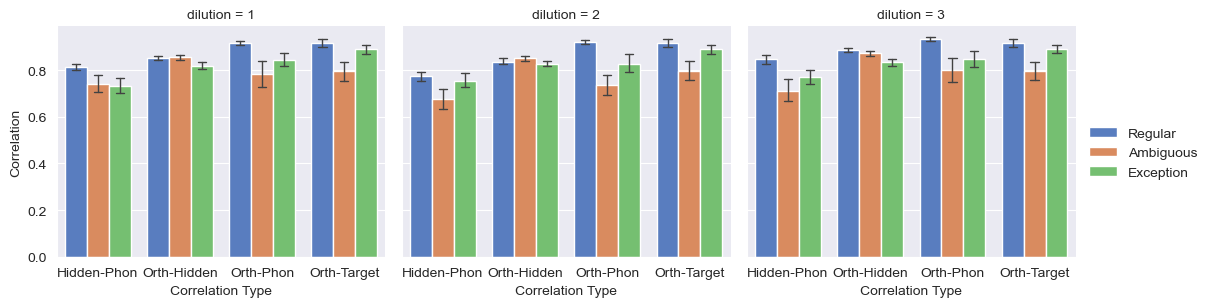

In [21]:
g = sns.FacetGrid(all_data[all_data['epoch'] == all_data['epoch'].max()], col='dilution', aspect=1.2)
g.map_dataframe(sns.barplot, x='corr_type', y='corr', hue='type', hue_order=TYPE_ORDER, ci=68, 
                palette='muted', errwidth=1, capsize=0.1)
g.set_axis_labels("Correlation Type", "Correlation")
g.add_legend()
plt.show()

## Checking for Outliers

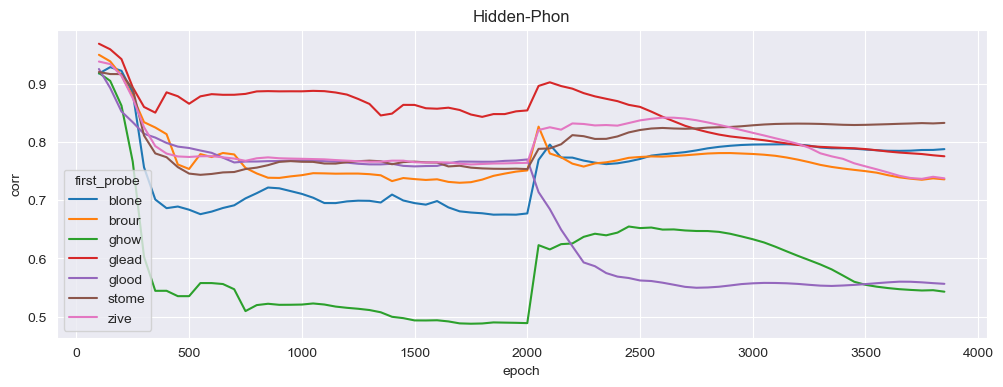

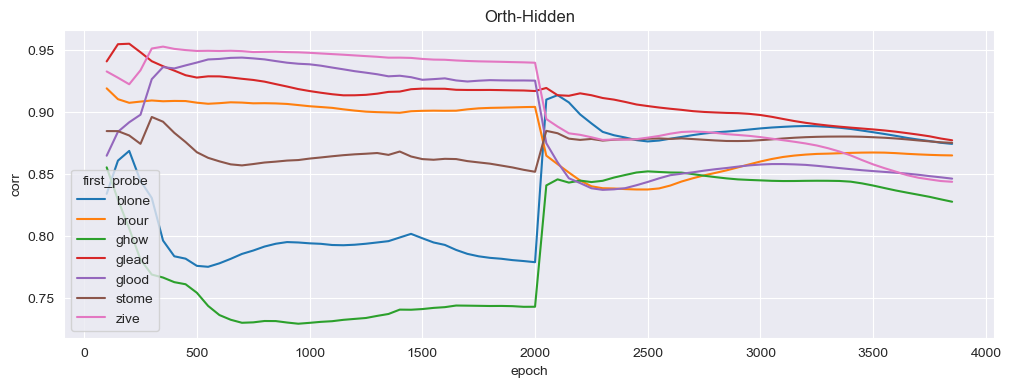

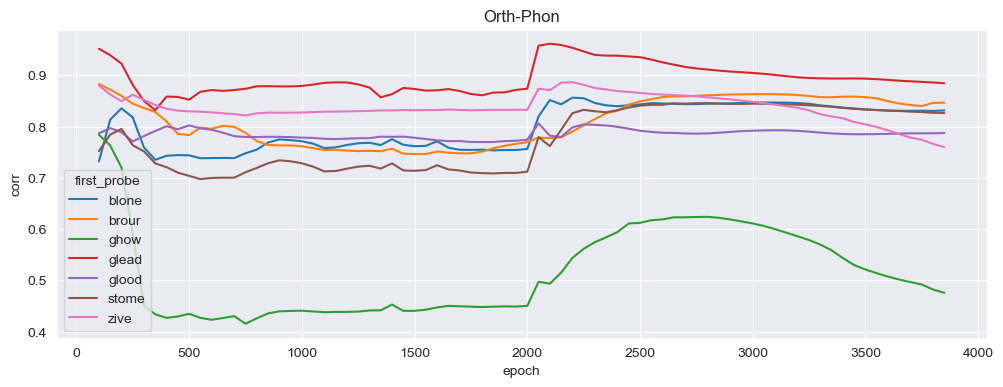

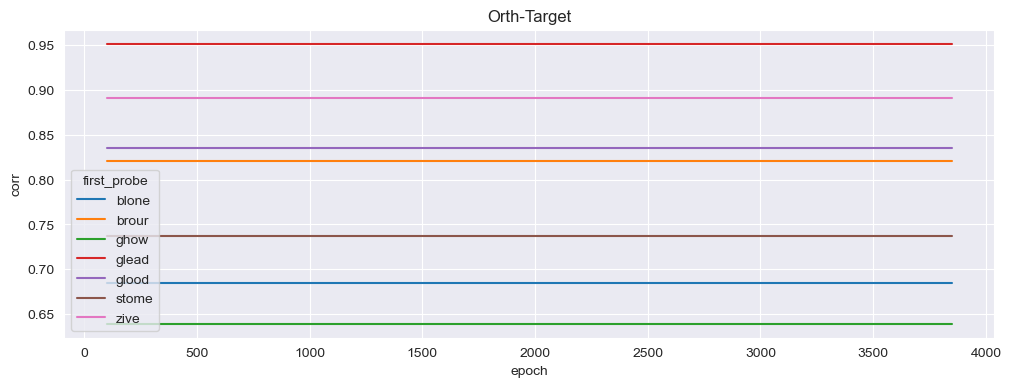

In [22]:
amb_data = all_data[all_data['type'] == 'Ambiguous']

for corr_type in amb_data['corr_type'].unique():
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=amb_data[amb_data['corr_type'] == corr_type], x='epoch', y='corr',
                 hue='first_probe', ci=None)
    plt.title(corr_type)
    plt.show()